In [1]:
# Initial setup for Jupyter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

import os
from math import erf, sqrt

import git
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import chi2
from scipy.linalg import sqrtm

import getdist
getdist.chains.print_load_details = False

# Path to the git repository root
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print(f"Path to git repo: {path_global}")

# ----------------------------------------------------------------------
# Global matplotlib configuration (fonts, math, outputs)
# ----------------------------------------------------------------------
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "cm",   # math symbols similar to Computer Modern
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ----------------------------------------------------------------------
# Plot style constants (single-column layout)
# ----------------------------------------------------------------------
COLUMN_WIDTH_IN = 3.37  # inches ~ 8.6 cm
SIZE_LABEL = 9
SIZE_TICK  = 9
SIZE_LEG   = 9
LW         = 0.8         # line width
QUIVER_W   = 0.006       # arrow width (inches, approx.)

# Local style context (to be used with mpl.rc_context)
rc = {
    "font.size": SIZE_TICK,
    "axes.titlesize": SIZE_LABEL,
    "axes.labelsize": SIZE_LABEL,
    "xtick.labelsize": SIZE_TICK,
    "ytick.labelsize": SIZE_TICK,
    "legend.fontsize": SIZE_LEG,
    "lines.linewidth": LW,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif"],
}

dark_violet = "#4B0082"


Path to git repo: /home/matias/Documents/PhD/code


Define some functions: 

In [2]:
def construct_C(vectors):
    L = len(vectors)

    K_xx = np.sum((vectors[:, 0]) ** 2)
    K_yy = np.sum((vectors[:, 1]) ** 2)
    K_xy = np.sum((vectors[:, 0]) * (vectors[:, 1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

In [3]:
def plot_geom_panel(
    ax,
    mean_A, mean_B, mean_C,
    cov_A, cov_B, cov_C,
    text_title,
    edge_labels,
    label_shifts=None,
):
    """
    Plot the tension-vector geometry for three Gaussian posteriors in a 2D
    shared parameter space.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis on which to draw the panel.
    mean_A, mean_B, mean_C : array_like, shape (2,)
        Means of the three datasets in the shared parameter space.
    cov_A, cov_B, cov_C : array_like, shape (2, 2)
        Covariance matrices of the three datasets in the shared parameter space.
    text_title : str
        Text label for the panel (e.g. 'CC–Planck–BAO').
    edge_labels : iterable of str
        Labels for the six tension vectors (r_1 ... r_6), in order:
        [label_r1, label_r2, label_r3, label_r4, label_r5, label_r6].
    label_shifts : dict, optional
        Optional manual shifts for label positions:
        {
            "AB": (dx, dy),
            "BC": (dx, dy),
            "CA": (dx, dy),
            "A'B": (...),
            ...
            "v1": (dx, dy),
            "v2": (dx, dy),
        }

        Here dx, dy are interpreted in units of a typical scale in the plot
        (base_range), and are added to the vector tip.

    Notes
    -----
    This function:
    - Computes the tension vectors r_k from the means and covariances.
    - Constructs the covariance C_tot of these vectors and its eigensystem.
    - Draws all tension vectors and the two principal directions (v1, v2).
    - Places labels for each vector and eigenvector, with optional manual offsets.
    - Computes and displays the eigenvalues and eccentricity in a small box.
    """

    # ------------------------------------------------------------------
    # Tension vectors r_k
    # ------------------------------------------------------------------
    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = -r_1
    r_5 = -r_2
    r_6 = -r_3

    R = np.vstack([r_1, r_2, r_3, r_4, r_5, r_6])

    # ------------------------------------------------------------------
    # Total covariance and eigensystem
    # ------------------------------------------------------------------
    C_tot = construct_C(R)
    evals, evecs = np.linalg.eigh(C_tot)
    idx = np.argsort(evals)[::-1]
    lam1, lam2 = evals[idx[0]], evals[idx[1]]
    v1 = evecs[:, idx[0]]
    v2 = evecs[:, idx[1]]

    ax.set_xlabel(r'$\Delta \Omega_m$')
    ax.set_ylabel(r'$\Delta H_0$')

    # Draw tension vectors
    for r in (r_1, r_2, r_3, r_4, r_5, r_6):
        ax.quiver(
            0, 0, r[0], r[1],
            angles='xy', scale_units='xy', scale=1,
            color=dark_violet, width=QUIVER_W, alpha=0.9
        )

    # Origin
    ax.scatter([0], [0], color='black', s=8)

    # Eigenvectors
    ax.quiver(
        0, 0, v1[0], v1[1],
        angles='xy', scale_units='xy', scale=1,
        color='black', width=QUIVER_W
    )
    ax.quiver(
        0, 0, v2[0], v2[1],
        angles='xy', scale_units='xy', scale=1,
        color='black', width=QUIVER_W
    )

    # ------------------------------------------------------------------
    # Typical scale and helper for label placement
    # ------------------------------------------------------------------
    base_range = np.max(np.abs(R)) if np.isfinite(R).all() else 1.0

    def compute_label_pos(r, text):
        """
        Compute the position of a label given the vector tip `r`
        and the label text `text`, using optional manual shifts.

        Parameters
        ----------
        r : array_like, shape (2,)
            Vector tip coordinates.
        text : str
            Label text, used as key in label_shifts if present.
        """
        # Manual shift (if provided), in units of base_range
        if (label_shifts is not None) and (text in label_shifts):
            dx, dy = label_shifts[text]
            return np.array([r[0] + dx * base_range, r[1] + dy * base_range])

        # Otherwise, use a simple automatic rule:
        # push the label slightly outward, then slightly inward for aesthetics
        offset = 0.06 * base_range
        inner_shift = 0.05 * base_range

        sx = 1 if r[0] >= 0 else -1
        sy = 1 if r[1] >= 0 else -1

        pos = np.array([r[0] + sx * offset, r[1] + sy * offset])
        pos[0] -= sx * inner_shift
        pos[1] -= sy * inner_shift
        return pos

    # ------------------------------------------------------------------
    # Label positions for all tension vectors and eigenvectors
    # ------------------------------------------------------------------
    l1, l2, l3, l4, l5, l6 = edge_labels

    lp_r1 = compute_label_pos(r_1, l1)
    lp_r2 = compute_label_pos(r_2, l2)
    lp_r3 = compute_label_pos(r_3, l3)
    lp_r4 = compute_label_pos(r_4, l4)
    lp_r5 = compute_label_pos(r_5, l5)
    lp_r6 = compute_label_pos(r_6, l6)

    lp_v1 = compute_label_pos(v1, "v1")
    lp_v2 = compute_label_pos(v2, "v2")

    # Collect all relevant points (vectors, eigenvectors, labels, origin)
    all_points = np.vstack([
        R,
        lp_r1, lp_r2, lp_r3, lp_r4, lp_r5, lp_r6,
        v1, v2,
        np.array([0.0, 0.0]),
    ])

    max_x = np.max(np.abs(all_points[:, 0]))
    max_y = np.max(np.abs(all_points[:, 1]))
    max_range_loc = max(max_x, max_y)

    pad = 0.10 * max_range_loc
    lim_x = (-max_range_loc - pad, max_range_loc + pad)
    lim_y = (-max_range_loc - pad, max_range_loc + pad)

    # ------------------------------------------------------------------
    # Draw labels
    # ------------------------------------------------------------------
    def label_at_vector(ax_, pos, text, color="black"):
        ax_.text(
            pos[0], pos[1], text,
            size=SIZE_LEG - 3,
            color=color
        )

    # Eigenvectors
    label_at_vector(ax, lp_v1, "v1", color="black")
    label_at_vector(ax, lp_v2, "v2", color="black")

    # Tension vectors
    label_at_vector(ax, lp_r1, l1, color=dark_violet)
    label_at_vector(ax, lp_r2, l2, color=dark_violet)
    label_at_vector(ax, lp_r3, l3, color=dark_violet)
    label_at_vector(ax, lp_r4, l4, color=dark_violet)
    label_at_vector(ax, lp_r5, l5, color=dark_violet)
    label_at_vector(ax, lp_r6, l6, color=dark_violet)

    # ------------------------------------------------------------------
    # Eccentricity and info box
    # ------------------------------------------------------------------
    lam_min = float(np.min(evals))
    lam_max = float(np.max(evals))
    ecc = np.sqrt(max(0.0, 1.0 - (lam_min / lam_max if lam_max > 0 else 0.0)))

    info_text = (
        rf"$\lambda_1 = {lam1:.3g}$" "\n"
        rf"$\lambda_2 = {lam2:.3g}$" "\n"
        rf"$\mathrm{{Ecc}} = {ecc:.3g}$"
    )

    ax.text(
        0.98, 0.02, info_text,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=SIZE_LEG,
        bbox=dict(
            boxstyle="round,pad=0.25",
            facecolor="white",
            alpha=0.9,
            edgecolor="black",
            linewidth=LW,
        ),
    )

    # ------------------------------------------------------------------
    # Axes limits, aspect, grid, and panel title
    # ------------------------------------------------------------------
    ax.set_xlim(*lim_x)
    ax.set_ylim(*lim_y)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.25, linewidth=LW * 0.8)

    ax.text(
        0.02, 0.98, text_title,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=SIZE_LEG - 2,
        bbox=dict(
            boxstyle="round,pad=0.25",
            facecolor="white",
            alpha=0.9,
            edgecolor="black",
            linewidth=LW,
        ),
    )


# Real Data

In [4]:
'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

os.chdir(os.path.join(path_global,'Cobaya','output','cluster','lcdm'))

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/lcdm_cc', no_cache=True,settings={'loglikes':True,'names':'CC','label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/lcdm_planck', no_cache=True,settings={'loglikes':True,'names':'Planck18','label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_desi_dr2/lcdm_desi_dr2', no_cache=True,settings={'loglikes':True,'names':'DESI DR2','label':'DESI DR2','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/lcdm_pps', no_cache=True,settings={'names':'PPS','label':'PPS','ignore_rows': '0.3'})


param_names = ['Omega_m','H0'] #Shared parameters
names = param_names
labels = ['\Omega_m','H_0']

#Estimate the mean and covariance of the chains:
mean_A_0 = chain_A.mean(param_names)
mean_B_0 = chain_B.mean(param_names)
mean_C_0 = chain_C.mean(param_names)
mean_D_0 = chain_D.mean(param_names)

cov_A_0 = chain_A.cov(param_names)
cov_B_0 = chain_B.cov(param_names)
cov_C_0 = chain_C.cov(param_names)
cov_D_0 = chain_D.cov(param_names)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


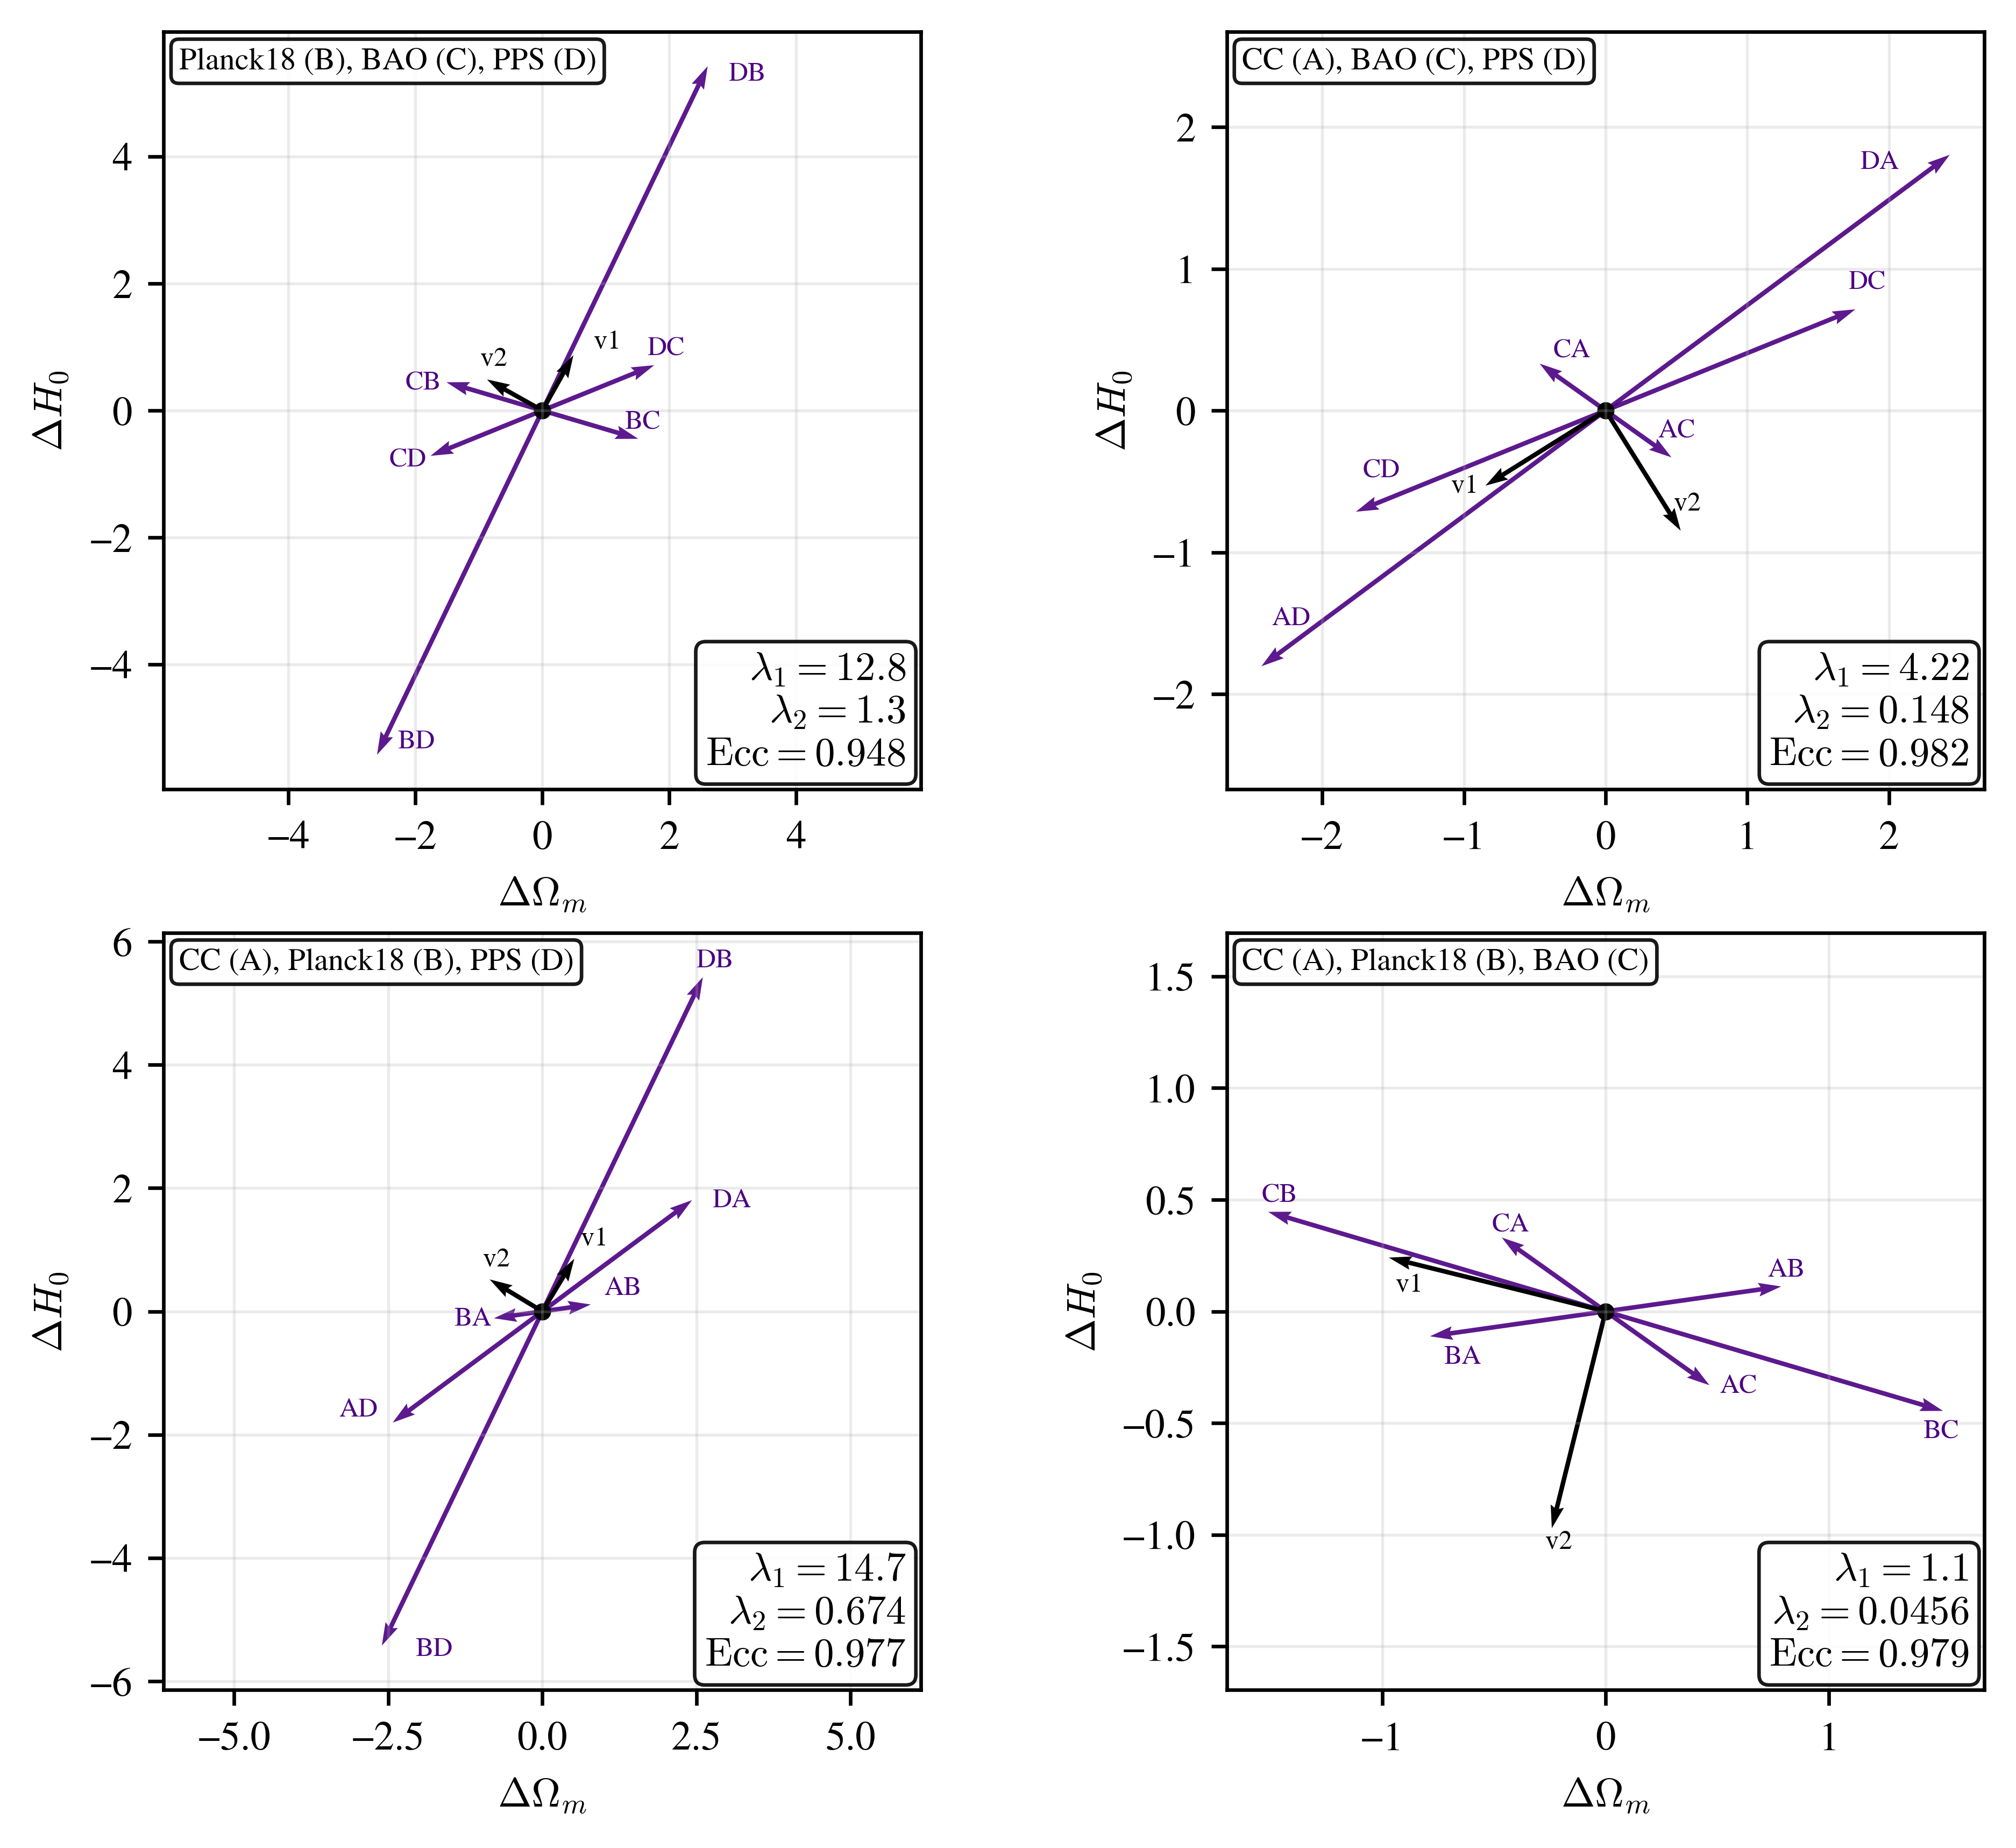

In [7]:
# ======================================================================
# Define the 4 configurations as a list of dictionaries
# ======================================================================

configs = [
    dict(   # without CC
        text_title='Planck18 (B), BAO (C), PPS (D)',
        name_plot='without_cc',
        mean_A=mean_B_0, cov_A=cov_B_0,   # B
        mean_B=mean_C_0, cov_B=cov_C_0,   # C
        mean_C=mean_D_0, cov_C=cov_D_0,   # D
        edge_labels=('BC', 'BD', 'CD', 'CB', 'DB', 'DC'),
        label_shifts={
            'BC': (-0.04,  0.03),
            'BD': ( 0.06,  0.02),
            'CD': (-0.12, -0.03),
            'CB': (-0.12, -0.02),
            'DB': ( 0.06, -0.04),
            'DC': (-0.02,  0.03),
            'v1': ( 0.06,  0.02),
            'v2': (-0.02,  0.04),
        },
    ),
    dict(   # without Planck
        text_title='CC (A), BAO (C), PPS (D)',
        name_plot='without_planck',
        mean_A=mean_A_0, cov_A=cov_A_0,   # A
        mean_B=mean_C_0, cov_B=cov_C_0,   # C
        mean_C=mean_D_0, cov_C=cov_D_0,   # D
        edge_labels=('AC', 'AD', 'CD', 'CA', 'DA', 'DC'),
        label_shifts={
            'AC': (-0.04,  0.06),
            'AD': ( 0.03,  0.12),
            'CD': ( 0.02,  0.10),
            'CA': ( 0.04,  0.02),
            'DA': (-0.26, -0.04),
            'DC': (-0.02,  0.06),
            'v1': (-0.10, -0.02),
            'v2': (-0.02,  0.06),
        },
    ),
    dict(   # without BAO
        text_title='CC (A), Planck18 (B), PPS (D)',
        name_plot='without_BAO',
        mean_A=mean_A_0, cov_A=cov_A_0,   # A
        mean_B=mean_B_0, cov_B=cov_B_0,   # B
        mean_C=mean_D_0, cov_C=cov_D_0,   # D
        edge_labels=('AB', 'AD', 'BD', 'BA', 'DA', 'DB'),
        label_shifts={
            'AB': ( 0.04,  0.03),
            'AD': (-0.16,  0.02),
            'BD': ( 0.10, -0.03),
            'BA': (-0.12, -0.02),
            'DA': ( 0.06, -0.02),
            'DB': (-0.02,  0.03),
            'v1': ( 0.02,  0.04),
            'v2': (-0.02,  0.04),
        },
    ),
    dict(   # without PPS
        text_title='CC (A), Planck18 (B), BAO (C)',
        name_plot='without_PPS',
        mean_A=mean_A_0, cov_A=cov_A_0,   # A
        mean_B=mean_B_0, cov_B=cov_B_0,   # B
        mean_C=mean_C_0, cov_C=cov_C_0,   # C
        edge_labels=('AB', 'AC', 'BC', 'BA', 'CA', 'CB'),
        label_shifts={
            'AB': (-0.04,  0.03),
            'AC': ( 0.03, -0.02),
            'BC': (-0.06, -0.08),
            'BA': ( 0.04, -0.08),
            'CA': (-0.03,  0.02),
            'CB': (-0.02,  0.03),
            'v1': ( 0.02, -0.10),
            'v2': (-0.02, -0.06),
        },
    ),
]

with mpl.rc_context(rc):
    fig_w, fig_h = 2 * COLUMN_WIDTH_IN, 2 * 2.8  # 2 columns × 2 rows
    fig, axes = plt.subplots(2, 2, figsize=(fig_w, fig_h))

    axes = axes.ravel()
    for ax, cfg in zip(axes, configs):
        plot_geom_panel(
            ax,
            mean_A=cfg["mean_A"], mean_B=cfg["mean_B"], mean_C=cfg["mean_C"],
            cov_A=cfg["cov_A"],   cov_B=cfg["cov_B"],   cov_C=cfg["cov_C"],
            text_title=cfg["text_title"],
            edge_labels=cfg["edge_labels"],
            label_shifts=cfg.get("label_shifts", None),
            # max_range=global_max_range,  # if plot_geom_panel supports it
        )

    fig.tight_layout(pad=0.3)

    output_dir = os.path.join(
        path_global, "multimeter", "notebooks", "paper_plots", "figures"
    )
    os.makedirs(output_dir, exist_ok=True)

    fig.savefig(os.path.join(output_dir, "geom_all_2x2.pdf"))
    fig.savefig(os.path.join(output_dir, "geom_all_2x2.svg"))
    fig.savefig(os.path.join(output_dir, "geom_all_2x2.png"), dpi=300)

    plt.show()
